<a href="https://colab.research.google.com/github/jfink09/Financial-Modeling/blob/Time-Series-Modeling/Modeling_Time_Series_With_Exponential_Smoothing_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Model time series with exponential smoothing methods and forecast Google's stock price

# Set up plots
%matplotlib inline
%config InclineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt 
import warnings

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import seaborn for cubehelix
import seaborn as sns

In [2]:
plt.set_cmap('cubehelix')
sns.set_palette('cubehelix')

# Define a list of four colors becuase standard colors are red, green, blue, and gray
COLORS = [plt.cm.cubehelix(x) for x in [0.1, 0.3, 0.5, 0.7]]

<Figure size 432x288 with 0 Axes>

In [3]:
# Install Yahoo Finance

!pip install --upgrade yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=dae0c45153306da3a960108e64467c7c40d6a945b9297c546827d722c9e0f33b
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [0]:
# Import libraries
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date
from statsmodels.tsa.holtwinters import (ExponentialSmoothing, SimpleExpSmoothing, Holt)

In [0]:
# Download Google's stock price
df = yf.download('GOOG', start='2010-01-01', end='2018-12-31', adjust=True, progress=False)

In [0]:
# Aggregate to a monthly frequency and rename the Adj Close column to adj_close
goog = df.resample('M') \
         .last() \
         .rename(columns={'Adj Close': 'adj_close'}) \
         .adj_close

In [0]:
# Create the training/test split
train_indices = goog.index.year < 2018
goog_train = goog[train_indices]
goog_test = goog[~train_indices]

test_length = len(goog_test)

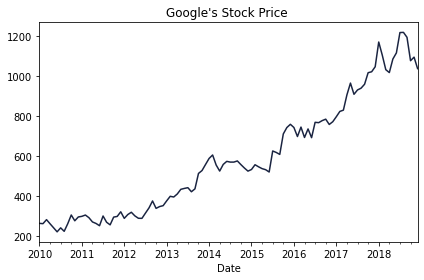

In [9]:
# Plot the price
goog.plot(title="Google's Stock Price ")
plt.tight_layout()
plt.show()

In [0]:
# Fit three SES models and create forecasts for them
ses_1 = SimpleExpSmoothing(goog_train).fit(smoothing_level=0.2)
ses_forecast_1 = ses_1.forecast(test_length)

ses_2 = SimpleExpSmoothing(goog_train).fit(smoothing_level=0.5)
ses_forecast_2 = ses_2.forecast(test_length)

ses_3 = SimpleExpSmoothing(goog_train).fit()
alpha = ses_3.model.params['smoothing_level']
ses_forecast_3 = ses_3.forecast(test_length)

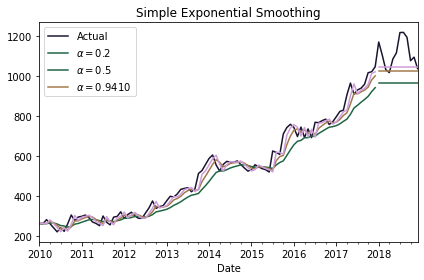

In [11]:
# Plot the original prices and the models' results
goog.plot(color=COLORS[0],
          title='Simple Exponential Smoothing',
          label='Actual',
          legend=True)

ses_forecast_1.plot(color=COLORS[1], legend=True,
                    label=r'$\alpha=0.2$')
ses_1.fittedvalues.plot(color=COLORS[1])

ses_forecast_2.plot(color=COLORS[2], legend=True,
                    label=r'$\alpha=0.5$')
ses_2.fittedvalues.plot(color=COLORS[2])

ses_forecast_3.plot(color=COLORS[3], legend=True,
                    label=r'$\alpha={0:.4f}$'.format(alpha))
ses_3.fittedvalues.plot(color=COLORS[3])

plt.tight_layout()
plt.show()

# The forecast was a straight line
# The optimal value selected by the statsmodels optimization routine was close to 1
# The fitted line of the third model was effectively the line of the observed prices shifted to the right

In [0]:
# Fit three variants of Holt's smoothing model and create forecasts

# Holt's model with linear trend
hs_1 = Holt(goog_train).fit()
hs_forecast_1 = hs_1.forecast(test_length)

# Holt's model with exponential trend
hs_2 = Holt(goog_train, exponential=True).fit()
hs_forecast_2 = hs_2.forecast(test_length)

# Holt's model with exponential trend and damping
hs_3 = Holt(goog_train, exponential=False,
            damped=True).fit(damping_slope=0.99)
hs_forecast_3 = hs_3.forecast(test_length)

# Holt(goog_train, exponential=True) is equivalent to ExponentialSmoothing(goog_train, trend='mul')

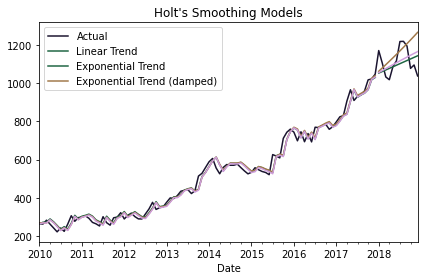

In [14]:
# Plot the original prices and the models' results
goog.plot(color=COLORS[0],
          title="Holt's Smoothing Models",
          label='Actual',
          legend=True)

hs_1.fittedvalues.plot(color=COLORS[1])
hs_forecast_1.plot(color=COLORS[1], legend=True,
                   label='Linear Trend')

hs_2.fittedvalues.plot(color=COLORS[2])
hs_forecast_2.plot(color=COLORS[2], legend=True,
                   label='Exponential Trend')

hs_3.fittedvalues.plot(color=COLORS[3])
hs_forecast_3.plot(color=COLORS[3], legend=True,
                   label='Exponential Trend (damped)')

plt.tight_layout()
plt.show()

# Now the forecasted values are not flat lines, but they do not show any variation during the forecast 

In [0]:
SEASONAL_PERIODS = 12

# Holt-Winter's model with exponential trend
hw_1 = ExponentialSmoothing(goog_train,
                            trend='mul',
                            seasonal='add',
                            seasonal_periods=SEASONAL_PERIODS).fit()
hw_forecast_1 = hw_1.forecast(test_length)

# Holt-Winter's model with exponential trend and damping
hw_2 = ExponentialSmoothing(goog_train,
                            trend='mul',
                            seasonal='add',
                            seasonal_periods=SEASONAL_PERIODS,
                            damped=True).fit()
hw_forecast_2 = hw_2.forecast(test_length)

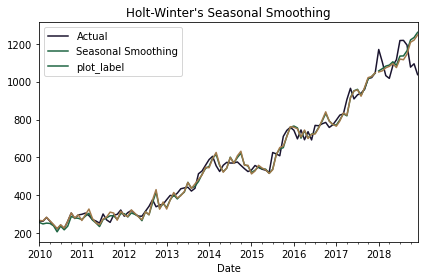

In [16]:
# Plot the results
goog.plot(color=COLORS[0],
          title="Holt-Winter's Seasonal Smoothing",
          label='Actual',
          legend=True)

hw_1.fittedvalues.plot(color=COLORS[1])
hw_forecast_1.plot(color=COLORS[1], legend=True,
                   label='Seasonal Smoothing')

phi = hw_2.model.params['damping_slope']
plot_label = f'Seasonal Smoothing (damped with $\phi={phi:.4f}$)'

hw_2.fittedvalues.plot(color=COLORS[2])
hw_forecast_2.plot(color=COLORS[2], legend=True,
                   label='plot_label')

plt.tight_layout()
plt.show()